In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append(os.path.realpath('..'))

In [3]:
import textwrap

import numpy as np
import pandas as pd
from scipy.stats import chi2

import plotly.express as ex
import plotly.graph_objects as go

from tracking_v2.kalman.turn import CoordinatedTurn
from tracking_v2.sensor import GeometricSensor
from tracking_v2.target import SingleTurnTarget, SinusTarget
from tracking.util import to_df

## Consequences of variance mismatch

Unlike in the linear Kalman Filter, where choosing the wrong value for the variance of the process or measurement noise, choosing the wrong variance for the turn rate in this implementation of the Extended Kalman Filter might lead to its unstable behavior.

In [12]:
def mismatched_run():
    target = SingleTurnTarget(30, 1)
    sensor = GeometricSensor(seed=0)
    true_positions = target.true_states()
    
    omega_sigma = np.sqrt(0.5) # effective variance will be 0.5
    
    sensor = GeometricSensor(seed=0)
    ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                          [0, 0, 1, 0, 0]],
                          [1, omega_sigma])
    t = 0
    ct.initialize(np.concatenate((true_positions[t, :2], [0, 0, 0])),
                  np.diag([1, 1, 1, 1, omega_sigma]))
    
    trace = []
    for _ in range(100):
        t += 1
        m = sensor.generate_measurement(t, true_positions[t, :3])
        noise = m.z[0, :2] - true_positions[t, :2]
    
        x_k = np.copy(ct.x_hat)
    
        ct.predict(1)
        ct.update(m.z[:, :2], m.R[:2, :2])
    
        trace.append(np.hstack(([t], noise.flat, target.heading()[t], ct.K[4,:].flat, ct.innovation.flat,
                                [ct.x_hat[4,0]], (ct.x_hat-x_k).flat)))
    
    trace = np.array(trace)
    trace = to_df(trace, columns=['t', 'x_noise', 'y_noise', 'heading', 'K_omega_x', 'K_omega_y', 'x_innov', 'y_innov',
                                  'omega_hat', 'x_delta', 'y_delta', 'vx_delta', 'vy_delta', 'o_delta'])
    trace['omega'] = np.concatenate(([0], np.diff(trace['heading'])))
    return trace

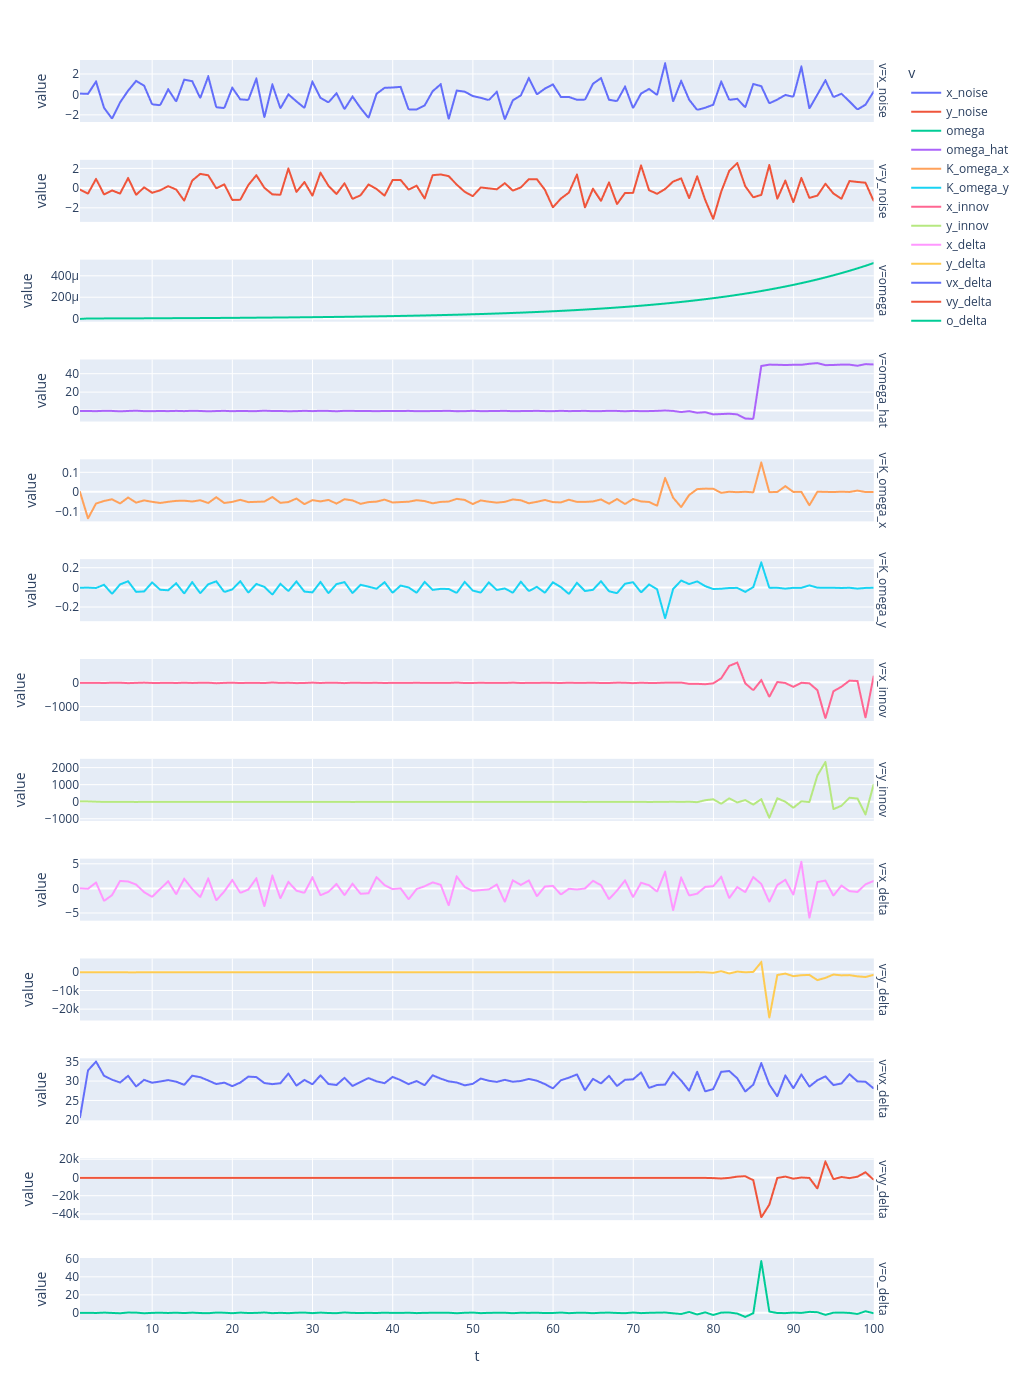

In [13]:
trace = mismatched_run()

fig = ex.line(trace.melt(['t'], ['x_noise', 'y_noise', 'omega', 'omega_hat', 'K_omega_x', 'K_omega_y', 'x_innov', 'y_innov',
                                 'x_delta', 'y_delta', 'vx_delta', 'vy_delta', 'o_delta'], 'v'),
              x='t', y='value', color='v', facet_row='v')
fig.update_yaxes(matches=None)
fig.update_layout(height=1400)
fig

### Step-by-step

At $t=85$, the filter produces. What happens at $t=83$?

In [24]:
class DebugCoordinatedTurn:
    def __init__(self, omega_sigma):
        self.target = SingleTurnTarget(30, 1)
        self.sensor = GeometricSensor(seed=0)
        self.true_positions = self.target.true_states()
        
        self.omega_sigma = omega_sigma
        
        self.sensor = GeometricSensor(seed=0)
        self.ct = CoordinatedTurn([[1, 0, 0, 0, 0],
                                   [0, 0, 1, 0, 0]],
                                   [1, self.omega_sigma])
        self.t = 0
        self.ct.initialize(np.concatenate((self.true_positions[self.t, :2], [0, 0, 0])),
                           np.diag([1, 1, 1, 1, self.omega_sigma]))
        
        self.trace_size = 6
        self.trace = []

    def run_for(self, n):
        for _ in range(n):
            self.t += 1
            m = self.sensor.generate_measurement(self.t, self.true_positions[self.t, :3])
        
            x_k = np.copy(self.ct.x_hat)
            
            self.ct.predict(1)
            self.ct.update(m.z[:, :2], m.R[:2, :2])
        
            self.trace.append((self.true_positions[self.t, :2], x_k.flatten(), m.z.flatten(), np.copy(self.ct.x_hat).flatten(), self.target.heading()[self.t]))
            while len(self.trace) > self.trace_size:
                self.trace.pop(0)

    def one_step(self):
        truth, x_k, z, x_k_1, heading = map(np.array, zip(*self.trace))
        
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=truth[:-1,0], y=truth[:-1,1], name='truth', line=dict(dash='dot')))
        fig.add_trace(go.Scatter(x=x_k[1:,0], y=x_k[1:,2], name='x_hat', line=dict(dash='dot')))
        fig.add_trace(go.Scatter(x=z[:-1,0], y=z[:-1,1], name='z', line=dict(dash='dot')))
        fig.add_trace(go.Scatter(x=[z[-1,0]], y=[z[-1,1]], name='next z'))
        fig.add_trace(go.Scatter(x=[x_k_1[-1,0]], y=[x_k_1[-1,2]], name='next x_hat'))
        fig.show()
    
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=np.arange(self.t-len(self.trace)+2, self.t+1), y=np.diff(heading), name="omega"))
        fig.add_trace(go.Scatter(x=np.arange(self.t-len(self.trace)+2, self.t+1), y=np.diff(x_k_1[:,4]), name="omega_hat"))
        fig.show()
        
        with np.printoptions(precision=4, suppress=True):
            self.t += 1
            m = self.sensor.generate_measurement(self.t, self.true_positions[self.t, :3])
            
            print("t:     ", self.t)
            print("pos:   ", self.true_positions[self.t, :2])
            print("vel:   ", self.true_positions[self.t, 3:5])
            print("head:  ", self.target.heading()[self.t])
            
            print()
            print("meas:  ", m.z)
            print("noise: ", m.z - np.concatenate((self.true_positions[self.t, :2], [self.target.heading()[self.t]])))
    
            x_k = np.copy(self.ct.x_hat)
    
            print("\nf_x: ", textwrap.indent(str(self.ct.f_x(1)), "        ")[6:])
            
            self.ct.predict(1)
    
            print("\nP_hat: ", textwrap.indent(str(self.ct.P_hat), "        ")[8:])
            print("\nP_hat @ H.T:\n", textwrap.indent(str(self.ct.P_hat @ self.ct.H.T), "        ")[1:])
    
            self.ct.update(m.z[:, :2], m.R[:2, :2])
    
            print("\nS: ", textwrap.indent(str(self.ct.S), "        ")[4:])
            print("\nS^1: ", textwrap.indent(str(np.linalg.inv(self.ct.S)), "        ")[6:])
    
            print()
            print("K:", end='')
            print(textwrap.indent(str(self.ct.K), "        ")[2:])
            print("inn:   ", self.ct.innovation.T)
    
            print("x_hat: ", self.ct.x_hat.T)
            print("delta: ", (self.ct.x_hat-x_k).T)
    
        self.trace.append((self.true_positions[self.t, :2], x_k.flatten(), m.z.flatten(), np.copy(self.ct.x_hat).flatten(), self.target.heading()[self.t]))
        while len(self.trace) > self.trace_size:
            self.trace.pop(0)

In [25]:
d = DebugCoordinatedTurn(np.sqrt(0.5))
d.run_for(80)

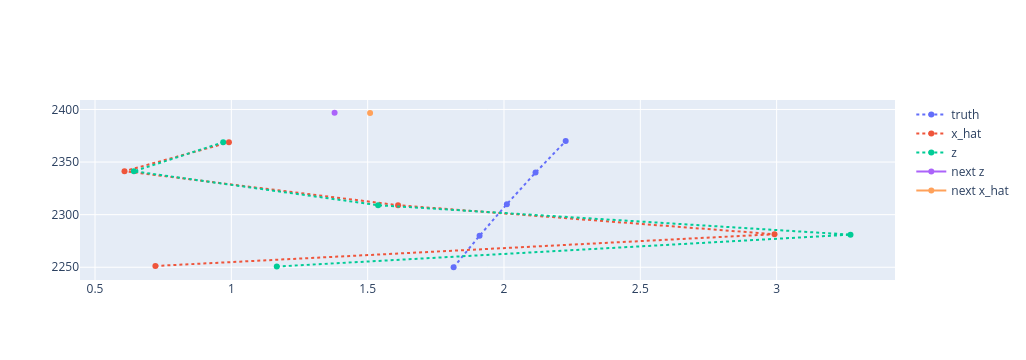

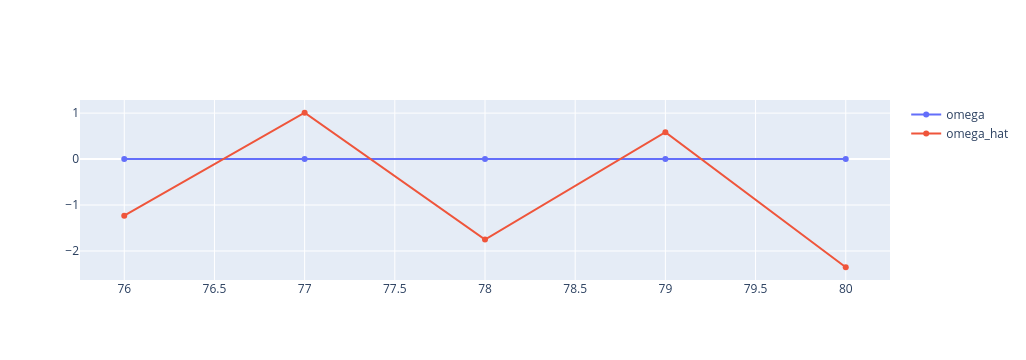

t:      81
pos:    [   2.4647 2429.9974]
vel:    [ 0.1256 29.9997]
head:   0.004185682359517705

meas:   [[   3.7616 2429.6517    0.8546]]
noise:  [[ 1.2969 -0.3457  0.8504]]

f_x:    [[   1.       -0.1331    0.        0.5136 -146.7127]
         [   0.       -0.8741    0.       -0.4858 -271.0565]
         [   0.       -0.5136    1.       -0.1331  -34.9697]
         [   0.        0.4858    0.       -0.8741  349.5792]
         [   0.        0.        0.        0.        1.    ]]

P_hat:  [[ 11657.2523  27732.7352   4404.487  -29309.2513    -91.1112]
         [ 20894.3223  47860.5306   7333.3323 -52077.9026   -160.3283]
         [  2526.5375   4976.8844    655.4592  -6097.586     -17.9844]
         [-29402.4501 -76717.1452 -12962.2704  75605.6865    242.0359]
         [   -77.1883   -172.4133    -26.0798    191.3038      1.0831]]

P_hat @ H.T:
        [[ 11657.2523   4404.487 ]
         [ 20894.3223   7333.3323]
         [  2526.5375    655.4592]
         [-29402.4501 -12962.2704]
       

In [26]:
d.one_step()

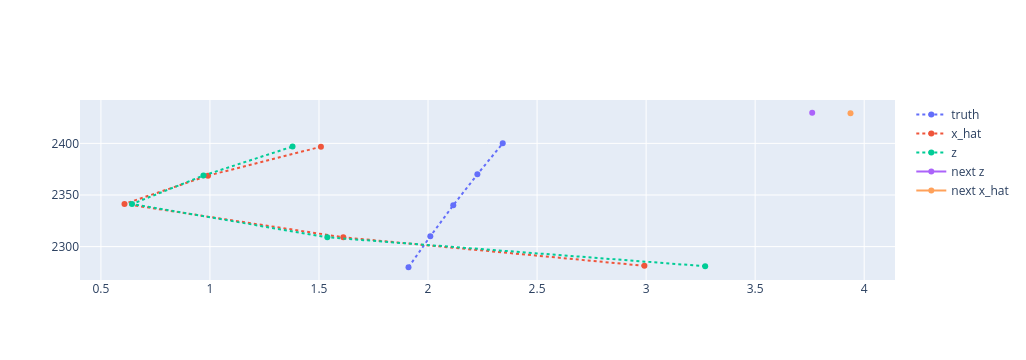

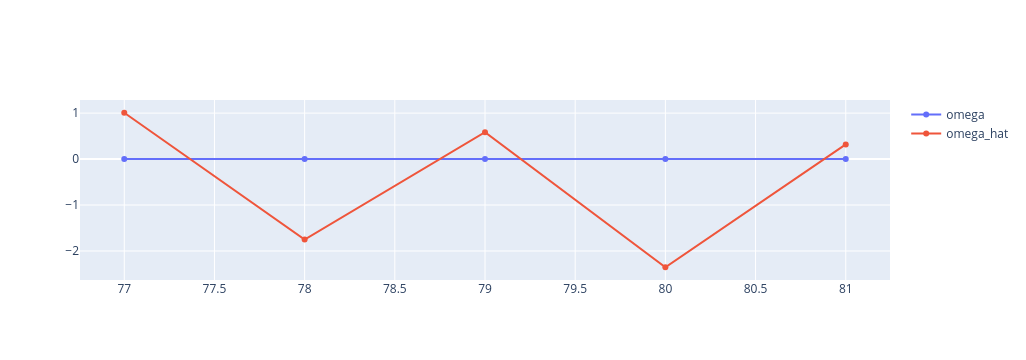

t:      82
pos:    [   2.5932 2459.9971]
vel:    [ 0.132  29.9997]
head:   0.004399685791574395

meas:   [[   2.1042 2461.7578    0.1992]]
noise:  [[-0.489   1.7607  0.1948]]

f_x:    [[    1.        -0.0561     0.         0.5954  -156.9382]
         [    0.        -0.9824     0.        -0.1869 -1199.0289]
         [    0.        -0.5954     1.        -0.0561  -412.7249]
         [    0.         0.1869     0.        -0.9824  -181.1802]
         [    0.         0.         0.         0.         1.    ]]

P_hat:  [[ 16508.9797  98338.2136  34239.6924   8671.396     -81.8753]
         [ 54991.8189 681091.8934 229595.8981 163070.8829   -572.9764]
         [ 21874.151  237329.7419  80363.298   52091.4034   -199.3433]
         [-23350.2392  72358.3292  20475.4877  68348.2382    -64.4038]
         [   -41.0659   -564.0115   -189.4201   -143.0436      0.9754]]

P_hat @ H.T:
        [[ 16508.9797  34239.6924]
         [ 54991.8189 229595.8981]
         [ 21874.151   80363.298 ]
         [-23350.

In [27]:
d.one_step()

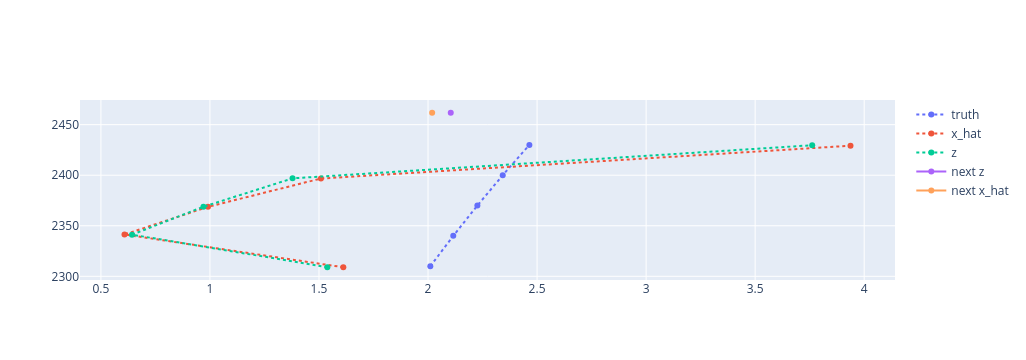

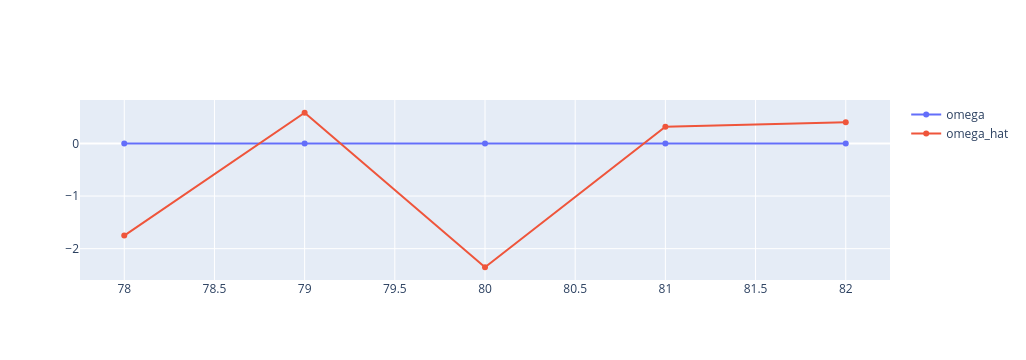

t:      83
pos:    [   2.7282 2489.9968]
vel:    [ 0.1387 29.9997]
head:   0.004624598382984592

meas:   [[   2.3462 2492.5492   -0.3245]]
noise:  [[-0.382   2.5524 -0.3291]]

f_x:    [[    1.         0.0737     0.         0.6759  -272.9781]
         [    0.        -0.9765     0.         0.2156 -1235.7317]
         [    0.        -0.6759     1.         0.0737  -400.6339]
         [    0.        -0.2156     0.        -0.9765   -39.8616]
         [    0.         0.         0.         0.         1.    ]]

P_hat:  [[-11574.1216 139397.2456  51154.038   66178.4126   -109.5793]
         [145762.6319 749962.9499 245917.4053  53194.4961   -605.4447]
         [ 52172.4073 246134.9556  80081.8858  11162.6898   -199.0784]
         [ 68381.6193  62748.2157  12509.7926 -77227.236     -55.3273]
         [   -83.5151   -586.2242   -196.4624    -85.9058      0.9711]]

P_hat @ H.T:
        [[-11574.1216  51154.038 ]
         [145762.6319 245917.4053]
         [ 52172.4073  80081.8858]
         [ 68381.

In [28]:
d.one_step()

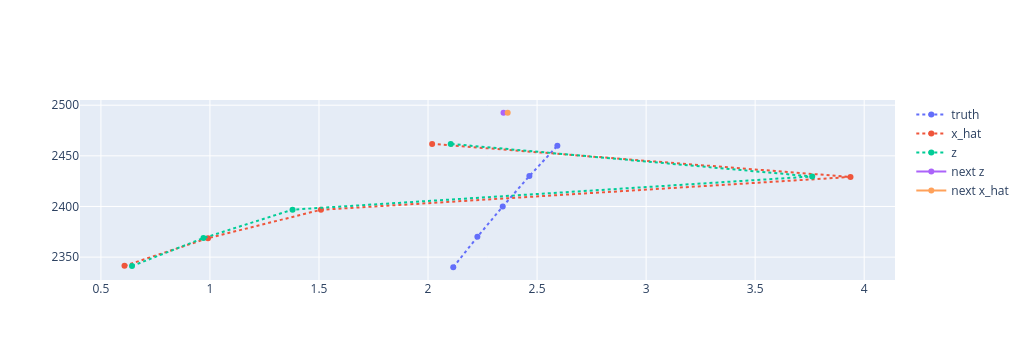

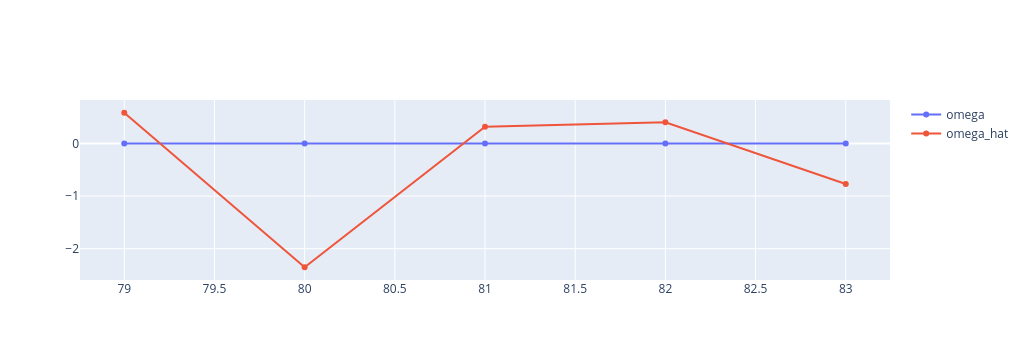

t:      84
pos:    [   2.8701 2519.9965]
vel:    [ 0.1458 29.9996]
head:   0.004860972859283108

meas:   [[   1.6488 2520.1984   -0.0388]]
noise:  [[-1.2212  0.2019 -0.0437]]

f_x:    [[   1.       -0.1421    0.        0.5011   47.2017]
         [   0.       -0.8512    0.       -0.5249   -4.8581]
         [   0.       -0.5011    1.       -0.1421  -22.5018]
         [   0.        0.5249    0.       -0.8512 -154.8095]
         [   0.        0.        0.        0.        1.    ]]

P_hat:  [[  799.8104   508.4518   -52.353  -2771.8955    16.6594]
         [ -586.6305  1452.1292   937.5814  1360.6556    -9.6697]
         [ -575.1099   179.0371   327.6847  1832.262    -11.8519]
         [-5807.8602  6312.8414  5733.2166 17188.1851  -119.1153]
         [   25.091     -6.1858   -13.8836   -81.2162     1.0307]]

P_hat @ H.T:
        [[  799.8104   -52.353 ]
         [ -586.6305   937.5814]
         [ -575.1099   327.6847]
         [-5807.8602  5733.2166]
         [   25.091    -13.8836]]

S:   

In [29]:
d.one_step()

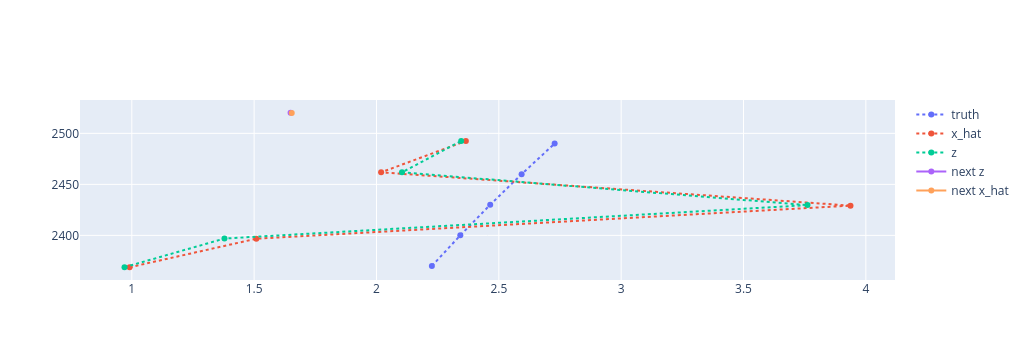

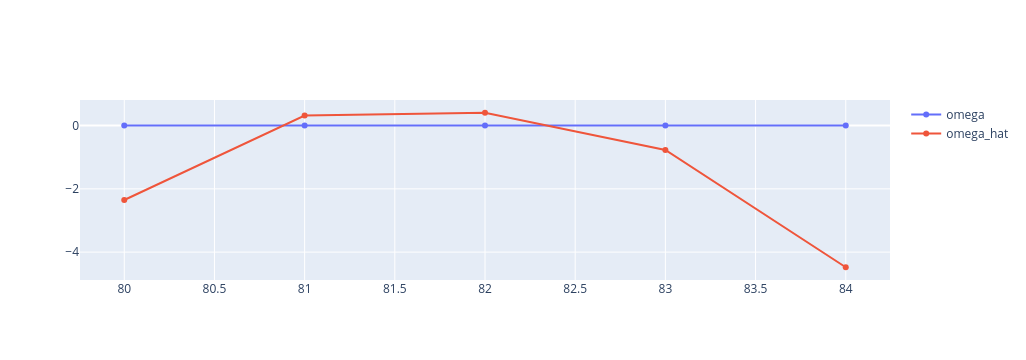

t:      85
pos:    [   3.0192 2549.9961]
vel:    [ 0.1533 29.9996]
head:   0.005109389595662179

meas:   [[   4.0855 2549.0745    0.8047]]
noise:  [[ 1.0663 -0.9216  0.7996]]

f_x:    [[   1.        0.1162    0.        0.1607 -169.4356]
         [   0.       -0.3131    0.        0.9497  708.7545]
         [   0.       -0.1607    1.        0.1162  109.983 ]
         [   0.       -0.9497    0.       -0.3131 1695.6228]
         [   0.        0.        0.        0.        1.    ]]

P_hat:  [[   2158.9331  -42977.5773   -5915.6168  -48813.6239     -33.1532]
         [ -74396.8013  262795.8297   42037.407   705773.3344     409.167 ]
         [ -10337.1491   39473.198     6229.4025  100435.0262      58.6546]
         [ -97084.7075  520660.3033   78573.4229 1063445.729      640.4131]
         [    -66.9706     320.2234      49.0014     702.3804       0.9185]]

P_hat @ H.T:
        [[  2158.9331  -5915.6168]
         [-74396.8013  42037.407 ]
         [-10337.1491   6229.4025]
         [-97084.

In [30]:
d.one_step()

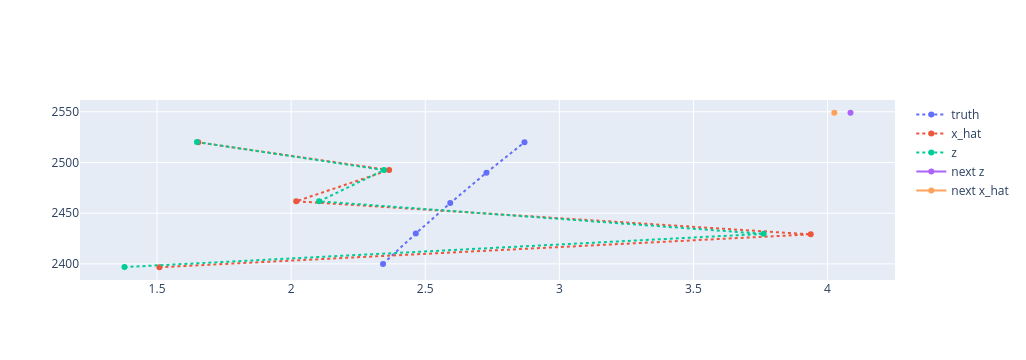

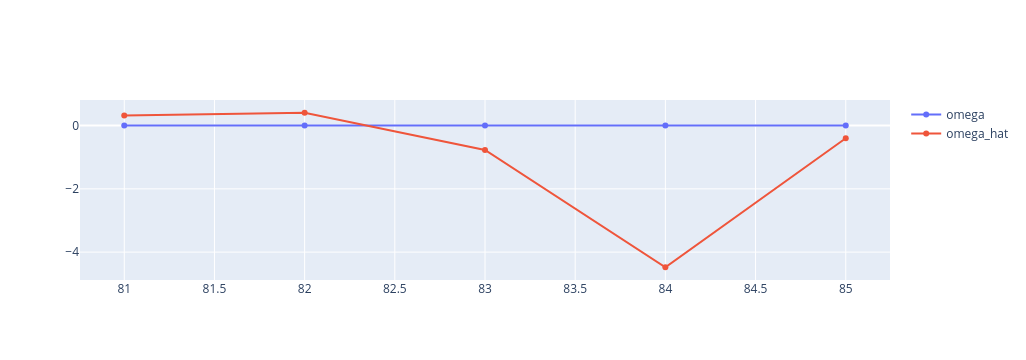

t:      86
pos:    [   3.176  2579.9957]
vel:    [ 0.1611 29.9996]
head:   0.005370457962895866

meas:   [[   4.0287 2579.328     0.1632]]
noise:  [[ 0.8527 -0.6677  0.1579]]

f_x:    [[   1.        0.0877    0.        0.1936   76.4203]
         [   0.       -0.6596    0.        0.7516 -235.0918]
         [   0.       -0.1936    1.        0.0877  -42.3535]
         [   0.       -0.7516    0.       -0.6596 -768.0809]
         [   0.        0.        0.        0.        1.    ]]

P_hat:  [[  4730.6738  -4056.081   -1098.1036 -37510.1287     42.1375]
         [-17242.8558   5089.4864   2388.4923 128819.7556   -140.3188]
         [ -2642.4009   2119.1754    560.9592  21015.5889    -24.0051]
         [-29106.8041  92225.1284  16876.8346 292852.1144   -377.6118]
         [    37.1268   -121.0237    -21.7286   -378.6178      0.9948]]

P_hat @ H.T:
        [[  4730.6738  -1098.1036]
         [-17242.8558   2388.4923]
         [ -2642.4009    560.9592]
         [-29106.8041  16876.8346]
       

In [31]:
d.one_step()

### Matched variance

In [32]:
d = DebugCoordinatedTurn(np.sqrt(0.02))
d.run_for(80)

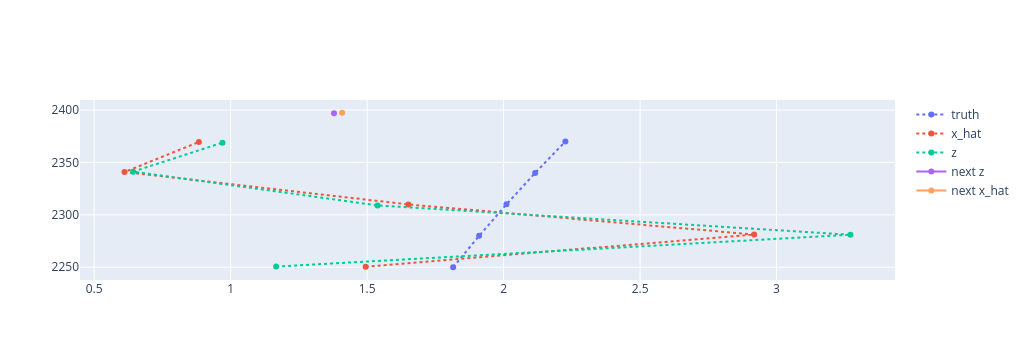

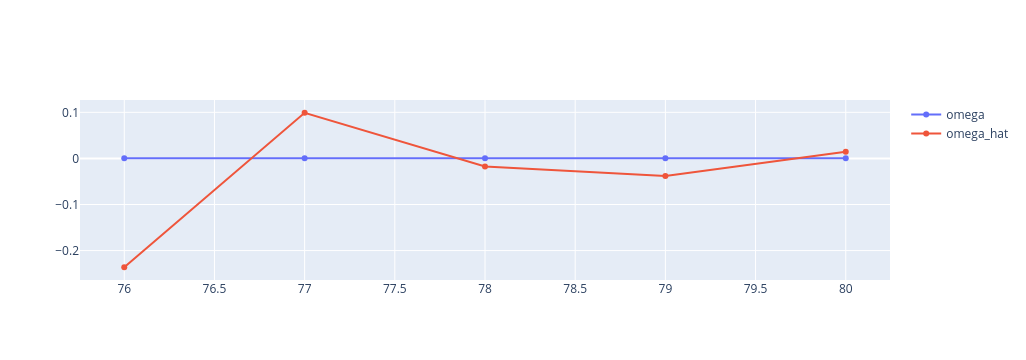

t:      81
pos:    [   2.4647 2429.9974]
vel:    [ 0.1256 29.9997]
head:   0.004185682359517705

meas:   [[   3.7616 2429.6517    0.8546]]
noise:  [[ 1.2969 -0.3457  0.8504]]

f_x:    [[  1.       0.9999   0.       0.0108 -14.1711]
         [  0.       0.9998   0.       0.0216 -28.3324]
         [  0.      -0.0108   1.       0.9999   0.6552]
         [  0.      -0.0216   0.       0.9998   1.5142]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[23.1597 30.5491 -1.1282 -1.7725 -0.6902]
         [30.5491 44.5339 -1.5759 -2.5662 -1.0985]
         [-1.1282 -1.5759  3.0672  2.1002  0.0382]
         [-1.7725 -2.5662  2.1002  2.1572  0.0648]
         [-0.6902 -1.0985  0.0382  0.0648  0.0508]]

P_hat @ H.T:
        [[23.1597 -1.1282]
         [30.5491 -1.5759]
         [-1.1282  3.0672]
         [-1.7725  2.1002]
         [-0.6902  0.0382]]

S:      [[24.1597 -1.1282]
         [-1.1282  4.0672]]

S^1:    [[0.0419 0.0116]
         [0.0116 0.2491]]

K:      [[ 0.9581 -0.0116]


In [33]:
d.one_step()

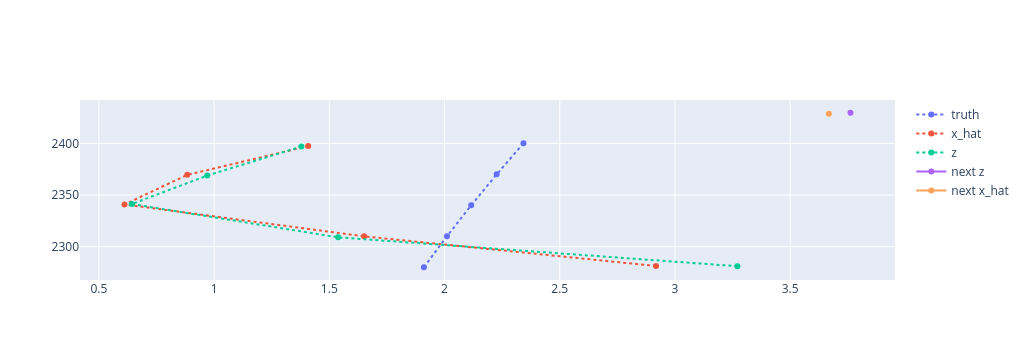

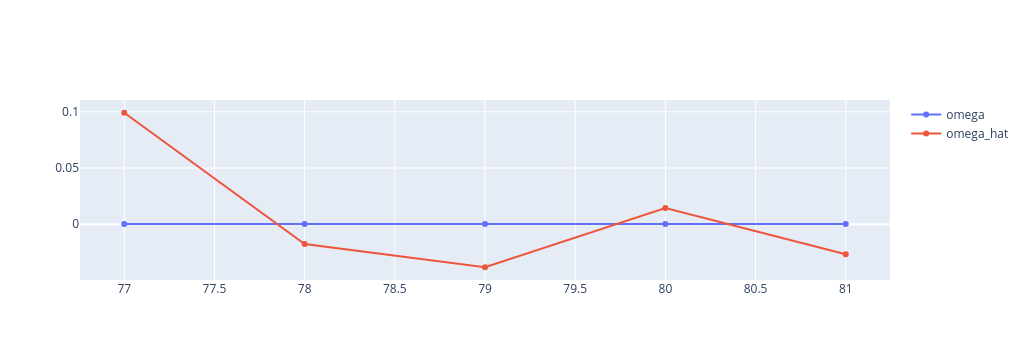

t:      82
pos:    [   2.5932 2459.9971]
vel:    [ 0.132  29.9997]
head:   0.004399685791574395

meas:   [[   2.1042 2461.7578    0.1992]]
noise:  [[-0.489   1.7607  0.1948]]

f_x:    [[  1.       0.9996   0.       0.0242 -15.0734]
         [  0.       0.9988   0.       0.0483 -30.0839]
         [  0.      -0.0242   1.       0.9996   1.8931]
         [  0.      -0.0483   0.       0.9988   4.2717]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[24.3244 32.7482 -2.1253 -4.0386 -0.7223]
         [32.7482 48.5205 -3.097  -6.1036 -1.1599]
         [-2.1253 -3.097   3.2155  2.4112  0.077 ]
         [-4.0386 -6.1036  2.4112  2.8047  0.1549]
         [-0.7223 -1.1599  0.077   0.1549  0.0511]]

P_hat @ H.T:
        [[24.3244 -2.1253]
         [32.7482 -3.097 ]
         [-2.1253  3.2155]
         [-4.0386  2.4112]
         [-0.7223  0.077 ]]

S:      [[25.3244 -2.1253]
         [-2.1253  4.2155]]

S^1:    [[0.0412 0.0208]
         [0.0208 0.2477]]

K:      [[ 0.9588 -0.0208]


In [34]:
d.one_step()

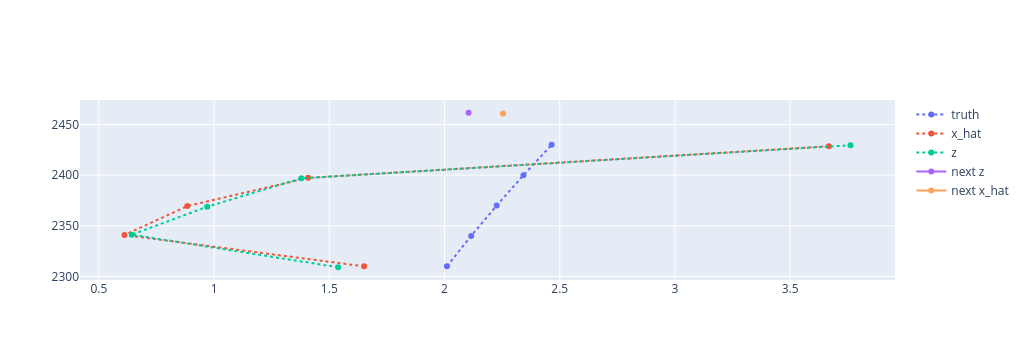

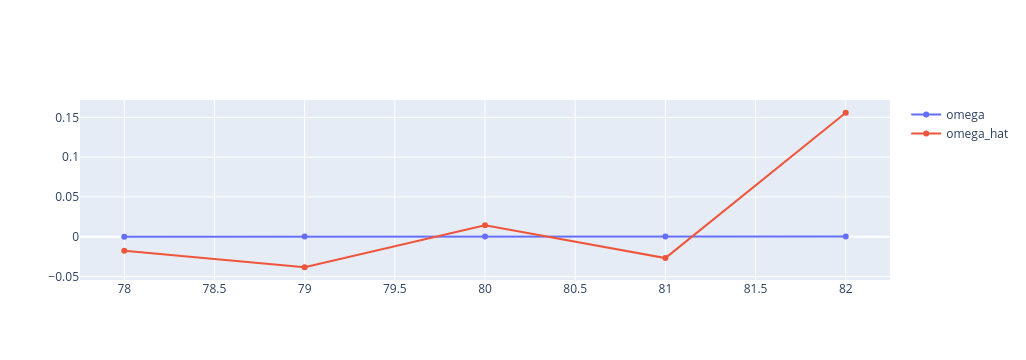

t:      83
pos:    [   2.7282 2489.9968]
vel:    [ 0.1387 29.9997]
head:   0.004624598382984592

meas:   [[   2.3462 2492.5492   -0.3245]]
noise:  [[-0.382   2.5524 -0.3291]]

f_x:    [[  1.       0.9981   0.      -0.0537 -15.9524]
         [  0.       0.9942   0.      -0.1072 -31.721 ]
         [  0.       0.0537   1.       0.9981  -2.4214]
         [  0.       0.1072   0.       0.9942  -5.9841]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[25.8301 35.071   0.8106  4.2401 -0.7393]
         [35.0709 52.2224  1.5252  6.7598 -1.1916]
         [ 0.8106  1.5252  3.1188  2.2972 -0.0504]
         [ 4.2401  6.7598  2.2972  3.0106 -0.175 ]
         [-0.7393 -1.1916 -0.0504 -0.175   0.0504]]

P_hat @ H.T:
        [[25.8301  0.8106]
         [35.0709  1.5252]
         [ 0.8106  3.1188]
         [ 4.2401  2.2972]
         [-0.7393 -0.0504]]

S:      [[26.8301  0.8106]
         [ 0.8106  4.1188]]

S^1:    [[ 0.0375 -0.0074]
         [-0.0074  0.2442]]

K:      [[ 0.9625  0.00

In [35]:
d.one_step()

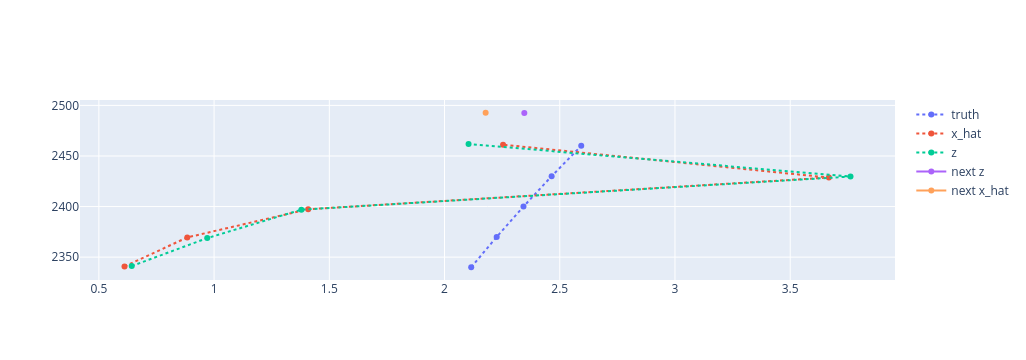

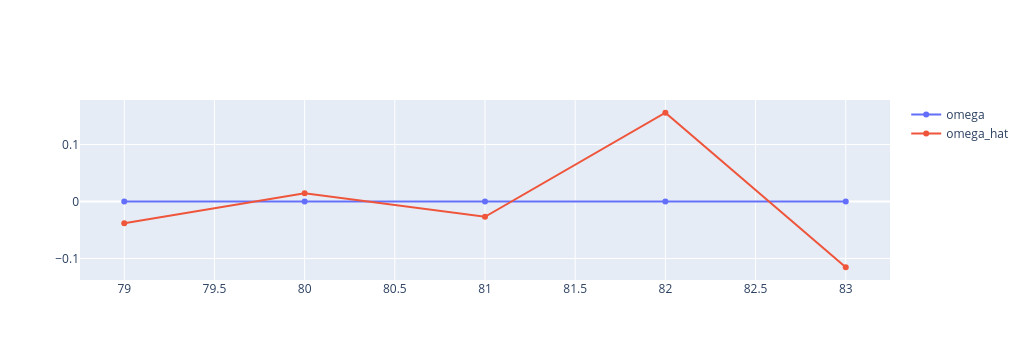

t:      84
pos:    [   2.8701 2519.9965]
vel:    [ 0.1458 29.9996]
head:   0.004860972859283108

meas:   [[   1.6488 2520.1984   -0.0388]]
noise:  [[-1.2212  0.2019 -0.0437]]

f_x:    [[  1.       1.       0.       0.004  -16.0197]
         [  0.       1.       0.       0.0079 -32.0398]
         [  0.      -0.004    1.       1.      -0.0962]
         [  0.      -0.0079   0.       1.      -0.1078]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[25.8148 35.0285  2.0699  1.8007 -0.7279]
         [35.0285 52.2458  2.7654  2.3878 -1.1791]
         [ 2.0699  2.7654  3.2579  2.2185 -0.0522]
         [ 1.8007  2.3878  2.2185  2.1856 -0.0448]
         [-0.7279 -1.1791 -0.0522 -0.0448  0.0499]]

P_hat @ H.T:
        [[25.8148  2.0699]
         [35.0285  2.7654]
         [ 2.0699  3.2579]
         [ 1.8007  2.2185]
         [-0.7279 -0.0522]]

S:      [[26.8148  2.0699]
         [ 2.0699  4.2579]]

S^1:    [[ 0.0387 -0.0188]
         [-0.0188  0.244 ]]

K:      [[ 0.9613  0.01

In [36]:
d.one_step()

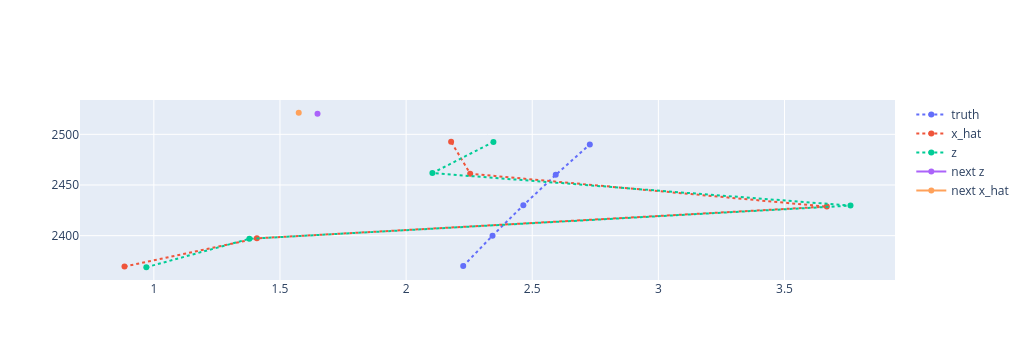

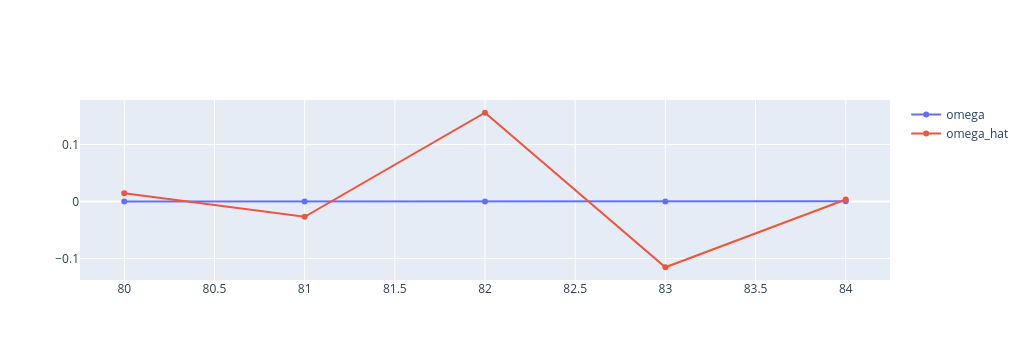

t:      85
pos:    [   3.0192 2549.9961]
vel:    [ 0.1533 29.9996]
head:   0.005109389595662179

meas:   [[   4.0855 2549.0745    0.8047]]
noise:  [[ 1.0663 -0.9216  0.7996]]

f_x:    [[  1.       1.       0.       0.0022 -14.8592]
         [  0.       1.       0.       0.0044 -29.7191]
         [  0.      -0.0022   1.       1.      -0.2369]
         [  0.      -0.0044   0.       1.      -0.4302]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[24.5453 32.5655  0.1658  0.2567 -0.7026]
         [32.5655 47.6328  0.1717  0.3716 -1.1226]
         [ 0.1658  0.1717  3.0303  2.0177 -0.0036]
         [ 0.2567  0.3716  2.0177  2.0125 -0.0099]
         [-0.7026 -1.1226 -0.0036 -0.0099  0.0501]]

P_hat @ H.T:
        [[24.5453  0.1658]
         [32.5655  0.1717]
         [ 0.1658  3.0303]
         [ 0.2567  2.0177]
         [-0.7026 -0.0036]]

S:      [[25.5453  0.1658]
         [ 0.1658  4.0303]]

S^1:    [[ 0.0392 -0.0016]
         [-0.0016  0.2482]]

K:      [[ 0.9608  0.00

In [37]:
d.one_step()

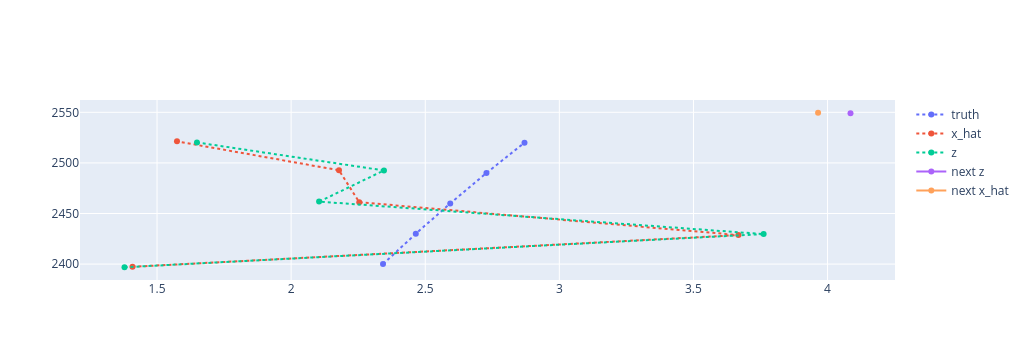

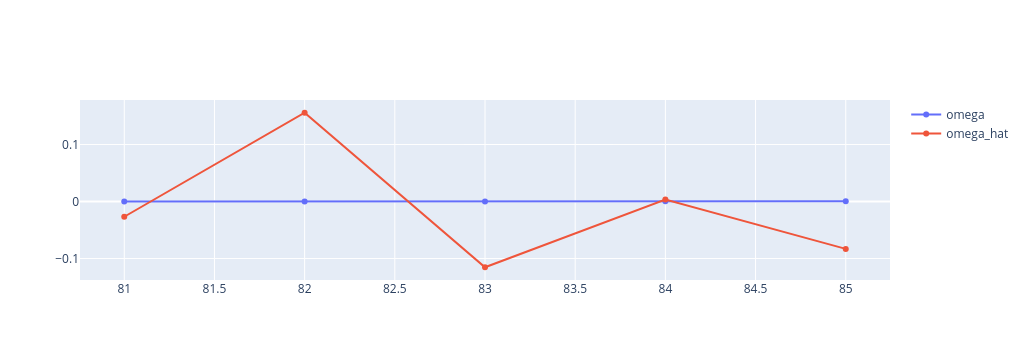

t:      86
pos:    [   3.176  2579.9957]
vel:    [ 0.1611 29.9996]
head:   0.005370457962895866

meas:   [[   4.0287 2579.328     0.1632]]
noise:  [[ 0.8527 -0.6677  0.1579]]

f_x:    [[  1.       0.9987   0.       0.0438 -14.2546]
         [  0.       0.9962   0.       0.0875 -28.3545]
         [  0.      -0.0438   1.       0.9987   2.547 ]
         [  0.      -0.0875   0.       0.9962   5.9252]
         [  0.       0.       0.       0.       1.    ]]

P_hat:  [[23.3669 30.7386 -2.0577 -4.873  -0.6928]
         [30.7386 44.6578 -3.075  -7.362  -1.0987]
         [-2.0577 -3.075   3.2415  2.5577  0.0852]
         [-4.873  -7.362   2.5577  3.3056  0.1989]
         [-0.6928 -1.0987  0.0852  0.1989  0.0508]]

P_hat @ H.T:
        [[23.3669 -2.0577]
         [30.7386 -3.075 ]
         [-2.0577  3.2415]
         [-4.873   2.5577]
         [-0.6928  0.0852]]

S:      [[24.3669 -2.0577]
         [-2.0577  4.2415]]

S^1:    [[0.0428 0.0208]
         [0.0208 0.2458]]

K:      [[ 0.9572 -0.0208]


In [38]:
d.one_step()